# Variational AutoEncoders (VAE)

Source: [Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)

Supposed we have a dataset of images. Each image has hundreds of pixels, so each "data point" has hundreds of dimensions. The **manifold hypothesis** states that real-world high-dimensional data can be sufficiently described using only a few dimensions.

Examples of dimensionality reduction techniques include **principal component analysis** (PCA) and **t-SNE**.

## Autoencoder

Autoencoders are neural networks used to perform dimensionality reduction composed of two networks, an **encoder** $e$ and a **decoder** $d$.

The **encoder** learns a non-linear transformation $e: X \to Z$ that projects data from the high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z = e(x)$ a **latent vector**. 

A **latent vector** is a low-dimensional **representation** of a data point that contains information about $x$.

A **decoder** learns a non-linear transformation $d: Z \to X$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector and reconstruct the original input data $\hat{x} = d(z)$.

An **autoencoder** is the composition of the encoder and the decoder

$$
f(x) = d(e(x))
$$

The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of **reconstruction loss** and simultaneosly optimizes the encoder and the decoder.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.manual_seed(0)
np.random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Autoencoder Model

![AE](images/autoencoder.svg)

In [2]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, z_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        z = self.linear2(x)
        return z


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    

class Autoencoder(nn.Module):
    def __init__(self, z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Training of MNIST Data

In [3]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__();

    def forward(self, predictions, target):
        loss_value = ((target - predictions)**2).sum()
        return loss_value

In [4]:
z_dim = 2
lr = 0.001
batch_size = 128
epochs = 80

autoencoder = Autoencoder(z_dim).to(device)

trainset = datasets.MNIST('.', transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_fn = MSELoss()

epoch_losses = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x, y in trainloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = autoencoder(x)
            loss = loss_fn(x, x_hat)
            epoch_loss = epoch_loss + loss.data.cpu()
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / len(trainloader)
        pbar.set_description(f'Epoch {epoch}, Loss: {epoch_loss:.2f}')
        pbar.update()
        epoch_losses.append(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

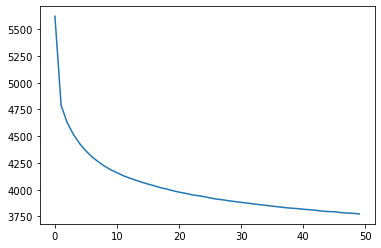

In [5]:
plt.plot(epoch_losses);

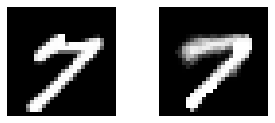

In [21]:
testset = datasets.MNIST(root='.', transform=transforms.ToTensor(), download=True, train=False)
testloader = DataLoader(testset, batch_size=128, shuffle=True, drop_last=True)

batch0 = next(iter(testloader))
img = batch0[0][0]
img_hat = autoencoder(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))
ax1.axis('off')
ax1.imshow(img.squeeze(0), cmap='gray')
ax2.axis('off')
ax2.imshow(img_hat.detach().squeeze(0).squeeze(0), cmap='gray');

### Latent Space

If we choose a **2-dimensional** latent space, then we can make a scatterplot of the output **latent vectors**.

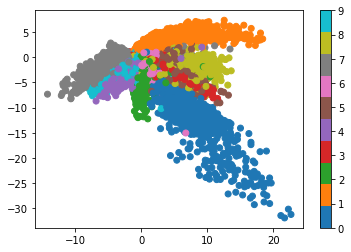

In [19]:
for x, y in testloader:
    z = autoencoder.encoder(x.to(device))
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar();

If we choose a **2-dimensional** latent space, then we can sample latent vectors $z$ from the latent space over a **uniform grid** and plot the decoded latent vectors on a grid.

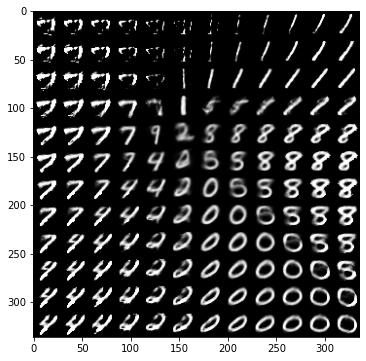

In [20]:
n = 12
w = 28
img = np.zeros((n * w, n * w))

for i, y in enumerate(np.linspace(-20, 10, 12)):
    for j, x in enumerate(np.linspace(-15, 20, 12)):
        z = torch.Tensor([[x, y]]).to(device)
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
        img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray');

If we sample a latent vector $z \sim Z$ from a region in the latent space that was never seen by the decoder during training, the output might not make any sense at all, see e.g. top-left corner.

The latent space $Z$ of an autoencoder can become **disjoint** and **non-continuous**. Variational autoencoders try to solve this problem.

## Variational Autoencoders

Instead of mapping the input $x$ to a latent vector $z=e(x)$, we map it to a **mean** vector $\mu(x)$ and a vector of **standard deviations** $\sigma(x)$ which parametrize a **diagonal Gaussian distribution** from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \, \sigma)$

This is modeled by replacing the last layer of an autoencoder with two layers, each of which outputs $\mu(x)$ and $\sigma(x)$.

There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an auxillary loss that penalizes the distribution $p\,(z∣x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$.

This penalty term is the **Kullback–Leibler divergence** between $p\,(z∣x)$ and $\mathcal{N}(0, 1)$ which is given by 

$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

(see [here](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians))

Implementing a variational autoencoder requires only to change the **encoder**:

## Variational Autoencoder Model

![VAE](images/variational-autoencoder.svg)

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc.to(device)
        self.N.scale.to(device)
        self.mu = torch.tensor([0, 0])
        self.sigma = torch.tensor([1, 1])
#        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        self.mu = self.linear2(x)
#        print(f'mu: {mu}')
        self.sigma = torch.exp(self.linear3(x))
#        print(f'sigma: {sigma}')
        self.z = self.mu + self.sigma * self.N.sample(self.mu.shape)
#        print(f'z: {z}')
#        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
#        print(f'self.kl: {self.kl}')
        return self.z

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Training of MNIST Data

In [7]:
class MSEKLLoss(nn.Module):
    def __init__(self):
        super(MSEKLLoss, self).__init__();

    def forward(self, predictions, target, mu, sigma):
        kl_divergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        loss_value = ((target - predictions)**2).sum() + kl_divergence
        return loss_value

In [8]:
z_dim = 2
lr = 0.001
batch_size = 128
epochs = 80

vae = VariationalAutoencoder(z_dim).to(device)

trainset = datasets.MNIST('.', transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
loss_fn = MSEKLLoss()

epoch_losses = []
kl_losses = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x, y in trainloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = vae(x)
#            loss = loss_fn(x, x_hat, vae.encoder.mu, vae.encoder.sigma)
            
            kl_divergence = (vae.encoder.sigma**2 + vae.encoder.mu**2 - torch.log(vae.encoder.sigma) - 1/2).sum()
            loss = ((target - predictions)**2).sum() + kl_divergence

            
            epoch_loss = epoch_loss + loss.data.cpu()
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / len(trainloader)
        epoch_losses.append(epoch_loss)
        pbar.set_description(f'Epoch {epoch}, Loss: {epoch_loss:.2f}')
        pbar.update()

  0%|          | 0/80 [00:00<?, ?it/s]

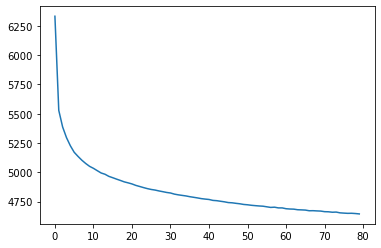

In [9]:
plt.plot(epoch_losses);

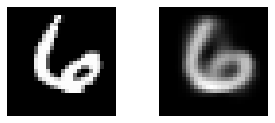

In [10]:
testset = datasets.MNIST(root='.', transform=transforms.ToTensor(), download=True, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

batch0 = next(iter(testloader))
img = batch0[0][0]
img_hat = vae(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))
ax1.axis('off')
ax1.imshow(img.squeeze(0), cmap='gray')
ax2.axis('off')
ax2.imshow(img_hat.detach().squeeze(0).squeeze(0), cmap='gray');

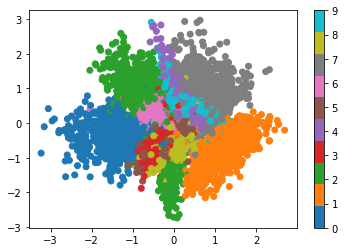

In [11]:
for x, y in testloader:
    z = vae.encoder(x.to(device))
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar();

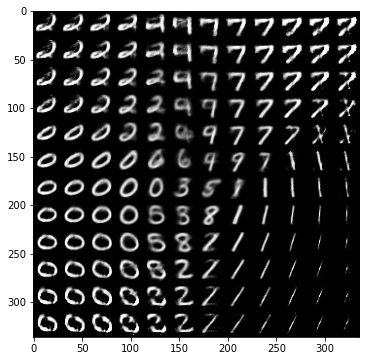

In [12]:
n = 12
w = 28
img = np.zeros((n * w, n * w))

for i, y in enumerate(np.linspace(-3, 3, 12)):
    for j, x in enumerate(np.linspace(-3, 3, 12)):
        z = torch.Tensor([[x, y]]).to(device)
        x_hat = vae.decoder(z)
        x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
        img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray');